In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Custom Functions:

In [2]:
# TODO: Docstring, function converts "list-like" to string
def unpack_list_like(list_like_series:pd.core.series.Series, asType:str) -> pd.core.series.Series:
    
    # Remove open and close square brackets, single-quotes, and replace commas with forward slashes
    unpacked_series = (list_like_series.str.replace("[","")
                       .str.replace("]","")
                       .str.replace("', '","/")
                       .str.replace("\'",""))
    
    return unpacked_series.astype(asType)

### Section 1: Load and Initial Assesment
In this section, the DataFrame is loaded in raw format in two zipped parts, and concatenated. The method `.info()` of the DataFrame class is used to gather initial insights about the DataFrame.

In [3]:
# Parse the dataset parts into DataFrames and concatenate them into a single DataFrame
games_sub1 : pd.core.frame.DataFrame = pd.read_csv("datasets/games_may2024_cleaned_1of2.zip", encoding='latin1', low_memory=False)
games_sub2 : pd.core.frame.DataFrame = pd.read_csv("datasets/games_may2024_cleaned_2of2.zip", encoding='latin1', low_memory=False)

games_raw : pd.core.frame.DataFrame = pd.concat([games_sub1, games_sub2])

# Intitial Assessment (info, memory usage, shape, and head)
print("="*20 + " DataFrame Information " + "="*20)
games_raw.info()
print("="*20 + " DataFrame Information " + "="*20)

print("\n" + "="*20 + " Memory Usage " + "="*20)
print(f"{games_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*20 + " Memory Usage " + "="*20)

print("\n" + "="*20 + " DataFrame Shape " + "="*20)
print(games_raw.shape)
print("="*20 + " DataFrame Shape " + "="*20)

print("\n" + "="*20 + " DataFrame Head " + "="*20)
print(games_raw.head())
print("="*20 + " DataFrame Head " + "="*20)

==================== DataFrame Information ====================
<class 'pandas.core.frame.DataFrame'>
Index: 83655 entries, 0 to 43542
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AppID                     83655 non-null  object
 1   name                      83652 non-null  object
 2   release_date              83653 non-null  object
 3   required_age              83654 non-null  object
 4   price                     83653 non-null  object
 5   dlc_count                 83653 non-null  object
 6   detailed_description      83488 non-null  object
 7   about_the_game            83460 non-null  object
 8   short_description         83539 non-null  object
 9   reviews                   10288 non-null  object
 10  header_image              83648 non-null  object
 11  website                   39764 non-null  object
 12  support_url               42085 non-null  object
 13  support_email    

### Section 2: Data Quality Assessment
In this section, the data values are examined to inform cleaning decisions.

In [4]:
# Find the number of NA values in each column
print("\n" + "="*20 + " NA Values" + "="*20)
print(games_raw.isna().sum())
print("="*20 + " NA Values " + "="*20)

# Find the number of unique values in each column
print("\n" + "="*20 + " Unique Values " + "="*20)
print(games_raw.nunique())
print("="*20 + " Unique Values " + "="*20)


==================== NA Values====================
AppID                           0
name                            3
release_date                    2
required_age                    1
price                           2
dlc_count                       2
detailed_description          167
about_the_game                195
short_description             116
reviews                     73367
header_image                    7
website                     43891
support_url                 41570
support_email               10585
windows                         8
mac                             7
linux                           8
metacritic_score                7
metacritic_url              79708
achievements                    7
recommendations                 7
notes                       69438
supported_languages             7
full_audio_languages            7
packages                        7
developers                      8
publishers                      7
categories                    

### Section 3: Cleaning Decisions
In this section, the DataFrame is cleaned based on the analysis of the previous section, as well as the return of the `.head()` method in Section 1. Section 1 is used to inform type casting decisions, and Section 2 is used to provide early warning of type casting errors.

#### Drop Unwanted Columns:
Columns that do not contribute to analysis of the dataset or aid in answering the question are dropped from the DataFrame in the code cell below.

In [5]:
# Remove unneeded columns from the dataframe using the .drop() method
games = games_raw.drop(columns=["required_age",
                              "dlc_count",
                              "detailed_description", 
                              "about_the_game", 
                              "short_description", 
                              "reviews", 
                              "support_url", 
                              "support_email", 
                              "estimated_owners",
                              "metacritic_score", 
                              "metacritic_url", 
                              "achievements", 
                              "recommendations", 
                              "notes",
                              "full_audio_languages",
                              "packages",
                              "categories",  
                              "screenshots", 
                              "movies",
                              "user_score", 
                              "score_rank", 
                              "tags",
                              "pct_pos_total",
                              "pct_pos_recent",
                              "average_playtime_forever", 
                              "average_playtime_2weeks", 
                              "median_playtime_forever",
                              "median_playtime_2weeks", 
                              "header_image", 
                              "website"])

#### Set the Index:
In Section 2, it was found that the column "AppID" has _nearly_ the same number of unique values (83653) as the number of rows (83655), making this a great index option. Furtheremore, this column has 0 NA values. For these reasons, "AppID" was selected as the index. Some values were found with clear encoding errors, these were scrapped in the process, as all columns in those rows were improperly encoded, and thus unusable.

In [6]:
# Set the index:
# Cast the "AppID" column to numeric (NA if not numeric-like) and drop rows with NA values
games['AppID'] = pd.to_numeric(games['AppID'], downcast='integer', errors='coerce')
games = games.dropna(subset=["AppID"])

# Convert remaining rows' "AppID" value to uint32 and then set the index of the DataFrame to this column
games["AppID"] = games['AppID'].astype('uint32')

# Set the data frame index to the "AppID" column
games = games.set_index("AppID")

#### Cast Column Data Types:
Three main types of columns are converted below:
1. Straight-forward string and numeric columns. These are converted to the most appropriate type using `.astype()` with a mapping of column:type pairs as the argument.
2. Columns that are "list-like" (e.g. \['English', 'Vietnamese'\]). These values are modified to be forward slash seperated for subsequent analysis (e.g. English/Vietnamese). Language columns are converted to strings, while genre, developer, and publisher columns are converted to categories due to a high count of repeat values as determined in Section 2.
3. Boolean values. The dataset uses "TRUE" and "FALSE" for its boolean values, which `.astype()` always interprets as True. To solve this problem, each of these columns are initially cast as string, and then are set equal to a boolean mask on the condition `df['col'] == "TRUE"`.

In [7]:
# Convert straightforward numeric and string column data types
games = games.astype({'name' : 'string',
                      'release_date' : 'datetime64[ns]',
                      'price' : 'float32',
                      'windows' : 'string',
                      'mac' : 'string',
                      'linux' : 'string',
                      'positive' : 'Int64',
                      'negative' : 'Int64',
                      'peak_ccu' : 'Int64',
                      'num_reviews_recent' : 'Int64'
                   })

# Convert the "list-like" columns from ['thing1','thing2'] string to "thing1/thing2" category or string
games["supported_languages"] = unpack_list_like(games["supported_languages"], asType='string')
games['developers'] = unpack_list_like(games["developers"], asType='category')
games['publishers'] = unpack_list_like(games["publishers"], asType='category')
games['genres'] = unpack_list_like(games["genres"], asType='category')

# Set incompatible boolean value columns equal to a bool mask to map TRUE to True and FALSE to False
games['windows'] = games['windows'].str.strip() == "TRUE"
games['mac'] = games['mac'].str.strip() == "TRUE"
games['linux'] = games['linux'].str.strip() == "TRUE"

# Report cleaned DataFrame size
print(f"The size of the cleaned DataFrame is {games.memory_usage(deep=True).sum() / 1024**2:.2f}MB")

# Find the number of unique values in each column
print("\n" + "="*20 + " Unique Values (Cleaned) " + "="*20)
print(games.nunique())
print("="*20 + " Unique Values (Cleaned) " + "="*20)

The size of the cleaned DataFrame is 34.61MB

==================== Unique Values (Cleaned) ====================
name                   83007
release_date            4498
price                    560
windows                    2
mac                        2
linux                      2
supported_languages    12791
developers             51512
publishers             44829
genres                  2601
positive                5057
negative                2500
peak_ccu                1165
num_reviews_total       5252
num_reviews_recent       793
dtype: int64
==================== Unique Values (Cleaned) ====================


### Section 4: Statistical EDA
In this section's subsections, several variables/groups of variables are characterized using statistical measurement and visualization transformations. Performing statistical and visual operations on these values allows their distributions to be understood, which provides insight into the measures and their assocaited values. First, individual features are analyzed, and then relations between various features are explored.

### Release Date EDA:
The goal of this section is to characterize the `release_date` column statistically and visually to understand how game release frequencies have changed over time. After cleaning this dataset, 83646 valid observations remain. Section 2 revealed that there are only 4503 unique release dates. As such, it becomes evident that a frequency analysis can provide some insight into the frequency distribution of game release dates. Since there are 4503 unique values of day/month/year, Pandas' built-in plotting struggles to handle axis labels, and as a result, these values were temporarily reduced to a year only value, as this alone is sufficient to understand the change in released game counts over time. Note: Logarithmic scale is used for the number of released games (y-axis) to esnure an insightful bar is plotted for early years (pre-2006) with low release counts. In addition to this frequency analysis, the average number of released games in a given year is computed.

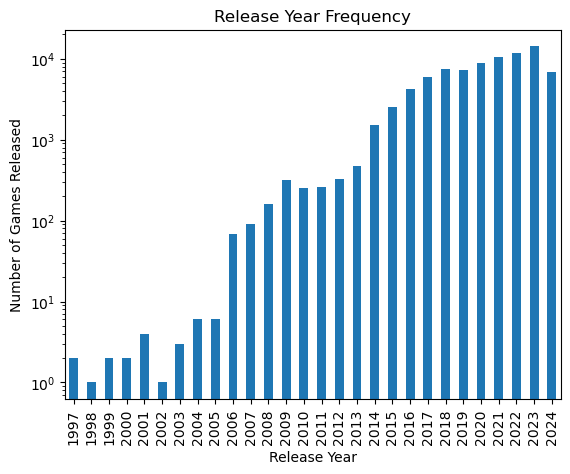


 Sorted Game Release Frequency by Year
release_date
2023    14224
2022    11837
2021    10656
2020     8921
2018     7495
2019     7354
2024     6912
2017     6013
2016     4190
2015     2538
2014     1538
2013      467
2012      324
2009      317
2011      260
2010      254
2008      160
2007       91
2006       68
2004        6
2005        6
2001        4
2003        3
2000        2
1999        2
1997        2
1998        1
2002        1
Name: count, dtype: int64

The average year has approximately 2987.4 games released.


In [8]:
# Create a new series of the release dates, with dates reduced to year only.
release_year_freq = (games['release_date']
                     .dt.year
                     .value_counts())

# Plot the release year frequency using Pandas
release_year_freq.sort_index().plot(kind='bar', 
                                    title="Release Year Frequency", 
                                    logy=True, xlabel='Release Year', 
                                    ylabel='Number of Games Released')
plt.show()

# Show the frequency of game releases, sorted by number of releases
print("\n Sorted Game Release Frequency by Year")
print(release_year_freq)

# Statistically characterize the release year distribution
print(f"\nThe average year has approximately {release_year_freq.mean():.1f} games released.")

### Game Price EDA:
The goal of this section is to characterize the price distribution of the games statistically and visually, across the dataset. Here, Pandas' `.describe()` method is used to statistically characterize the distribution of the `price` continuous variable. Furthermore, a logarithmic plot is provided to understand the _entire_ distribution due to the existance of a handful of games in the 975-1000 USD range. Additionally, a histogram is provided in the 0-75 USD range to characterize the _heavy_ majority of the distribution, as shown by the logarithmic plot.

count    83646.000000
mean         7.492446
std         13.091960
min          0.000000
25%          0.990000
50%          4.990000
75%          9.990000
max        999.979980
Name: price, dtype: float64


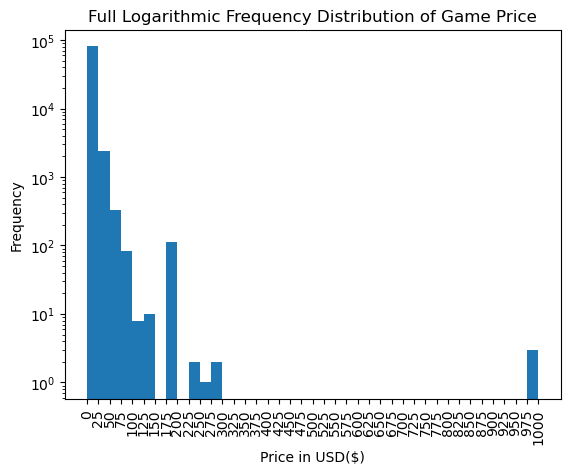

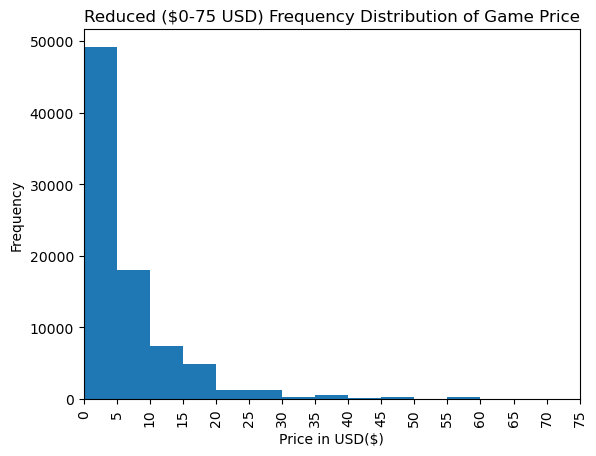

In [9]:
# Statistically descibe the distribution of the price column
print(games['price'].describe())

# Plot the entire frequency of prices using a histogram, syncing bins with xticks
bins_xticks_range = range(0, 1001, 25)
games['price'].plot(kind='hist', 
                    title="Full Logarithmic Frequency Distribution of Game Price", 
                    logy=True, 
                    xlabel="Price in USD($)", 
                    bins=bins_xticks_range, 
                    xticks=bins_xticks_range, 
                    rot=90
                   )
plt.show()

# Plot the reduced frequency of prices using a histogram, syncing bins with xticks
bins_xticks_range_reduced = range(0, 80, 5)
games['price'].plot(kind='hist', 
                    title="Reduced ($0-75 USD) Frequency Distribution of Game Price",  
                    xlabel="Price in USD($)", 
                    bins=bins_xticks_range_reduced, 
                    xticks=bins_xticks_range_reduced, 
                    rot=90,
                    xlim=(0,75)
                   )
plt.show()

### Operating System Offering EDA:
In this section, the operating system offerings of the games in the dataset are analyzed. The counts of games offered on each OS is reported below.

Windows has 83610 games available.
Macintosh has 16741 games available.
Linux has 11751 games available.


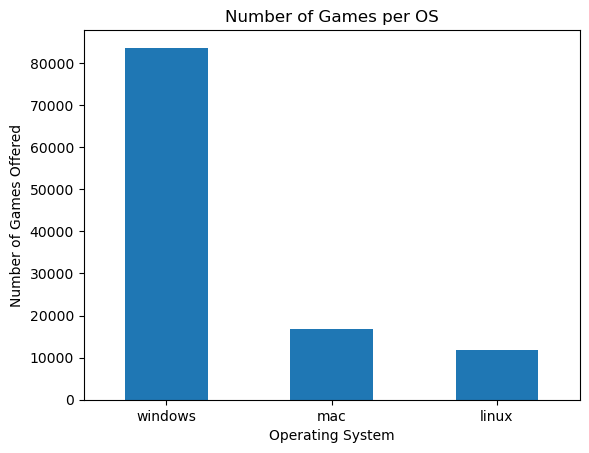

In [12]:
# Report the counts of each operating systems' games
print(f"Windows has {games['windows'].sum()} games available.")
print(f"Macintosh has {games['mac'].sum()} games available.")
print(f"Linux has {games['linux'].sum()} games available.")

games[['windows', 'mac', 'linux']].sum().plot(kind='bar',
                                              title="Number of Games per OS",
                                              xlabel='Operating System',
                                              ylabel='Number of Games Offered',
                                              rot=0)
plt.show()

### User Review (Positive/Negative) EDA:
In this section, the number of user reviews (both positive and negative) are statistically analyzed. Additionally, positive and negative reviews are plotted in a single figure to offer a side-by side comparison of the two measures. Note here that the use of the `.describe()` method is primarily used to inform plot parameter selection, and the key takeaways of the statistical measures of these features is restated after the plot.

Positive Review Statistics:
count         83640.0
mean      1276.694381
std      30577.722242
min               0.0
25%               1.0
50%              11.0
75%              64.0
max         7024836.0
Name: positive, dtype: Float64

Negative Review Statistics:
count        83640.0
mean      207.202367
std      5792.526703
min              0.0
25%              0.0
50%              3.0
75%             19.0
max        1029779.0
Name: negative, dtype: Float64


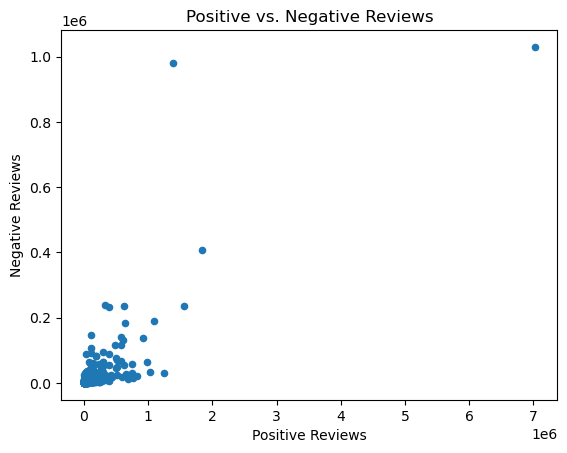

In [11]:
# Statistically characterize the number of positive reviews
print("Positive Review Statistics:")
print(games['positive'].describe())

# Statistically characterize the number of negative reviews
print("\nNegative Review Statistics:")
print(games['negative'].describe())

# Plot the histograms of positive and negative reviews in a single figure
games.plot(kind='scatter', 
           x='positive', 
           y='negative',
           xlabel='Positive Reviews',
           ylabel='Negative Reviews',
           title='Positive vs. Negative Reviews'
          )
plt.show()

### Section 5: Transform

### Section 6: Document